<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Working_with_Experimental_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Working with Experimental Data**
---
Welcome to Particle Identification Playground! In this activity, you will learn about the structure of particle physics data and implement PID methods as functions that can be applied to real data!

**Before attempting this notebook, complete all of the activities in the Getting Started section and the Particle Identification Methods section.**

**After completing this notebook, you will be able to:**
*   Recognize common elements of the data produced by particle physics detectors
*   Implement PID methods as functions that can be used on experimental data

In [ ]:
#@title Run this cell before starting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
##**HDDM Data Format**
---
In this notebook, we will take a closer look at the data format used by the GlueX experiment. Although most experiments tend to use similar formats, the vocabulary used by each experiment may be slightly different. It is also worth noting that this format is not "raw" data. It is said to be reconstructed ("rest" for short). Individual hits in the detector are not listed in this file format. Instead, it only includes information about the tracks and showers that can be detected from those hits.

---
##**Events**
---
Files are broken down into **events**. An event is a single occurrence of an interaction that we are trying to study. For example, in the GlueX experiment, an event is an interaction between the photon beam and a proton in the target. This interaction produces tons of particles that are also considered part of the event. The goal of analyzing the data produced by this event is to use the particles we detected to study what happened to produce those particles.

Each event contains information about the particles we detected. Expand the sections below to see the structure of the HDDM file format used for the GlueX experiment.

---
###**chargedTracks**
---


Within each event, there are sections labeled "chargedTrack". Each of these sections represents a single track hypothesis. A hypothesis is a track fit (A best guess for the path the particle took), along with a guess for the identity of the particle. For example, let's say that a collection of 10 hits in the central drift chamber were produced by the same particle. In the rest file, this may be recorded as 4 chargedTrack hypotheses depending on the charge of the particle: Proton or AntiProton, K+ or K-, Pi+ or Pi-, and Positron or Electron.

Why is it useful to break down a single physical track into multiple hypotheses? In the "Drift Chambers and Track" notebook, we mentioned that as a particle passes through the straws of the drift chamber, it loses a small amount of energy (and some momentum too). We claimed that it was negligible for track fitting, but in reality, it does have an effect on the curvature of the track. By testing out all of these hypotheses, we can take this energy loss effect into account, and more accurately measure the momentum and trajectory of the particle. The goal of PID is to pick which hypothesis is the "true" hypothesis. Note that there is no muon or antimuon hypothesis, because their masses are extremely similar to pions, so their track fits should be similar. Also, there is no PID method used by GlueX that is able to distinguish between pions and muons. However, some other experiments have specific **muon detectors** that are used to identify muons.

Because different hypotheses will have different paths through the detector, different hypotheses will have different associated information. For example, the path length from the vertex to the barrel calorimeter may be different for an electron hypothesis and a proton hypothesis. In practice, these differences are fairly small (only a few centimeters), but these differences are still important to take into account.

Each chargedTrack listing contains the following information:

*   **ptype:** The hypothesized particle type
*   **CandidateID:** A number that matches hypotheses that are produced from the same collection of hits. If two chargedTracks have the same candidateID, then they refer to hypotheses for the same collection of hits. Only one of these hypotheses should be used for analysis (otherwise we will count the same track multiple times)
*   **px, py, and pz:** The components of the momentum vector of the particle.
*   **chisq:** The Chi-squared value for the track fit. Chi-squared is a test of how good the fit is. The lower the chi-squared value, the better the track fit lines up with the observed hits.
*   **measuredCDChits and measuredFDChits:** The number of hits that are included in the track (in the central drift chamber and the forward drift chambers respectively). Sometimes people make cuts on the number of hits to make sure that tracks have enough hits in the drift chamber to get a good estimate of the path of the particle.
*   **dEdxCDC and dEdxFDC:** The ionization energy loss of the particle in the central drift chamber and the forward drift chamber.

There is a lot more information contained in these chargedTrack hypotheses, but these are the most widely used.

---
###**bCalShowers**
---

Information about the showers produced in the barrel calorimeter (bCal) is stored in the "bCalShower" sections of the event. Each shower gets its own section. Unlike tracks, guessing the particle that produced the shower doesn't necessarily improve anything about our understanding of that shower. As a result, each bCalShower represents a physical shower in the detector, and we don't need to worry about finding a "true" shower in a group of hypotheses.

The bCalShower sections contain the following information:

*   **E:** The total energy of the shower.
*   **t:** The time at which the shower was produced. This time can be used for time of flight in the barrel calorimeter. The time of flight is $t_{shower}-t_{vertex}$.
*   **x, y, and z:** The position of the starting point of the shower.
*   **sigLong** The standard deviation of the depth of the hits in the barrel calorimeter. This can provide information about how "long" the shower is.
*   **sigTrans** The standard deviation of the distance of the hits from the "center" of the shower. This can provide information about the "width" of the shower.
*   **sigTrans** The standard deviation of the angle of the hits around the "center" of the shower. This can provide information about the symmetry of the shower.
*   **E_L2, E_L3, and E_L4:** The energy deposited in the second layer, third layer, and fourth layer of the barrel calorimeter. The energy deposited in the first layer is not listed, because the total energy $E$ of the shower is simply the sum of of the energies deposited in each layer. In other words, $\mbox{E_L1} = \mbox{E} - \left (\mbox{E_L2} + \mbox{E_L3} + \mbox{E_L4}\right )$.

---
###**fCalShowers**
---

Information about the showers produced in the forward calorimeter (fCal) is stored in the "fCalShower" sections of the event. Just like bCalShowers, each shower gets its own section, so we don't need to worry about finding a "true" shower in a group of hypotheses.

The fCalShower sections contain the following information:

*   **E:** The total energy of the shower.
*   **t:** The time at which the shower was produced.
*   **x, y, and z:** The position of the starting point of the shower.
*   **E1E9:** The ratio of the energy deposited in the center of the shower (E1) and the energy deposited in the surrounding 3x3 group of blocks (E9).
*   **E9E25:** The ratio of the energy deposited in the 3x3 group of blocks around the center of the shower (E9) and the energy deposited in the surrounding 5x5 group of blocks (E25).

---
###**bcalMatchParams**
---

Many showers are produced by charged particles, which should have also produced a track. To try and match tracks with the barrel calorimeter showers that follow them, "bcalMatchParams" (short for "barrel calorimeter match parameters") are included near the end of the event. However, because there are multiple hypotheses for each track, there is one bcalMatchParams section for each hypothesis.

The bcalMatchParams section contains the following information:

*   **shower:** The index of the barrel calorimeter shower that is being matched.
*   **track:** The index of the chargedTrack that is being matched. This is not the candidateID. Instead, it is the index of the specific chargedTrack section that is being matched.
*   **pathlength:** The distance between the vertex and the matched shower. This can be used for time of flight analysis in the barrel calorimeter.
*   **tflight:** The calculated time of flight based on the hypothesis of the track. The measured time of flight can be calculated based on the time of the shower.

---
###**fcalMatchParams**
---

To match tracks with showers in the forward calorimeter, "fcalMatchParams" (short for "barrel calorimeter match parameters") are included near the end of the event. Again, because there are multiple hypotheses for each track, there is one fcalMatchParams section for each hypothesis.

The fcalMatchParams section contains the following information:

*   **shower:** The index of the forward calorimeter shower that is being matched.
*   **track:** The index of the chargedTrack that is being matched. This is not the candidateID. Instead, it is the index of the specific chargedTrack section that is being matched.
*   **pathlength:** The distance between the vertex and the matched shower. This can be used for time of flight analysis in the forward calorimeter.
*   **tflight:** The calculated time of flight based on the hypothesis of the track. The measured time of flight can be calculated based on the time of the shower.

---
###**dircMatchParams**
---

Charged particles may also interact with the DIRC detector. To associate tracks and DIRC hits, dircMatchParams are included near the end of the event. As with other match parameters, one section is included for each hypothesis.

The information in the dircMatchParams section includes:

*   **lele:** Log likelihood of the DIRC hit belonging to an electron
*   **lpi:** Log likelihood of the DIRC hit belonging to a pion
*   **lk:** Log likelihood of the DIRC hit belonging to a kaon
*   **lp:** Log likelihood of the DIRC hit belonging to a proton

---
###**scMatchParams**
---

The start counter is a scintillator detector that surrounds the target. It detects charged particles that are produced inside the target, and for this reason, when it is matched to a track, it will be duplicated and matched for each hypothesis. It is able to collect lots of information that can be used for PID, but because of how small it is, its resolution isn't as good as the other detectors. However, in cases where information from other detectors isn't available, start counter hits can be used for PID.

The information included in the scMatchParams section includes:

*   **track:** The index of the track this match is associated with. This is not the candidate ID of the track- it is the index of the chargedTrack in the list of all chargedTracks.
*   **thit:** The time at which the particle interacted with the start counter.
*   **pathlength:** The distance the hypothesized particle traveled between the event vertex (the "starting point") and the start counter hit. This can be used for time of flight analysis.
*   **tflight**: The calculated time of flight that the hypothesized particle would take to travel the path length specified above.
*   **dEdx:** The ionization energy loss of the particle in the start counter.

---
###**tofMatchParams**
---

The tofMatchParams match a forward time of flight detector hit to a track. As with the other match parameters, there is one copy of the match parameters for each track hypothesis.
The information included in the tofMatchParams section includes:

*   **track:** The index of the track this match is associated with. This is not the candidate ID of the track- it is the index of the chargedTrack in the list of all chargedTracks.
*   **thit:** The time at which the particle interacted with the time of flight detector.
*   **pathlength:** The distance the hypothesized particle traveled between the event vertex (the "starting point") and the time of flight detector hit. This can be used for time of flight analysis.
*   **tflight**: The calculated time of flight that the hypothesized particle would take to travel the path length specified above.
*   **dEdx:** The ionization energy loss of the particle in the time of flight detector.

---
##**Working with a DataFrame**
---
Because each track has multiple hypotheses, multiple rows in the dataframe will represent the same particle under different hypotheses. When we go to apply our PID method, we need to check each hypothesis. Therefore, one way of performing PID is to just check each hypothesis with a true/false classifier.

For example, let's say we have a track with three hypotheses. Each of these hypotheses might have slightly different momenta, different path lengths, different calculated times of flight, etc., which could affect the decision of our PID method. We might create a PID function called `isProton`, which takes a row of the dataframe as an input, then outputs `True` if the hypothesis satisfies the PID conditions to be considered a proton, and `False` if the hypothesis does not satisfy the PID conditions to be considered a proton. This would be repeated with each hypothesis, as is shown in the image below.

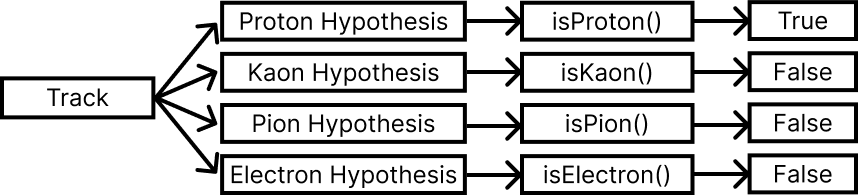

Something worth noting is that we don't need a separate function for antiparticles. The cuts for antiparticles are the same, so we can use the same `isProton` function for both protons and antiprotons (for example).

To implement different PID methods, you will need to change all of the functions for all of the different hypotheses to apply the corresponding cuts. However, the general evaluation scheme will stay the same.

The cell below implements the `isProton()` function for ionization energy loss in the GlueX central drift chamber (CDC).

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-4.8*p+3.6)+1.5:
    return True
  else:
    return False

The function `isProton()` takes a row of a dataframe (which we called `particle`), and uses the data in that row to implement a cut on the ionization energy loss of the particle. If the particle passes that cut, the function returns `True`, which tells us that the track was produced by a proton. If the particle fails the cut, then the function returns `False`, which tells us that the track is not a proton.

####**Question #1:**
---
In this question, you will write the general evaluation scheme that we will use for PID methods. Suppose we have already defined four functions:

*   isProton()
*   isKaon()
*   isPion()
*   isElectron()

Each of these functions takes a row of the dataframe (`particle`) as an input, and outputs `True` or `False`. Use these functions to complete the `identify_particle` function below.

In [ ]:
def identify_particle(particle):
  if particle['Hypothesis'] == "Proton" and #complete this code
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and #complete this code
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and #complete this code
    return "K+"
  elif particle['Hypothesis'] == "K-" and #Complete this code
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and #complete this code
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and #complete this code
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and #complete this code
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and #complete this code
    return "Positron"
  else:
    return "No ID"

#####**Solution:**

In [ ]:
def identify_particle(particle):
  if particle['Hypothesis'] == "Proton" and isProton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and isProton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and isKaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and isKaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and isPion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and isPion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and isElectron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and isElectron(particle):
    return "Positron"
  else:
    return "No ID"

####**Question #2:**
---
Below is the function you wrote in the "Ionization Energy Loss" notebook. Based on this function, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **px, py, and pz** - The components of the momentum vector
*   **CDC dEdx** - The ionization energy loss of the track in the central drift chamber.

In [ ]:
def identify_particle(p, dEdx):
  if dEdx *10**6> np.exp(-2.5*p+2.3)+1.4:
    return "Proton"
  elif dEdx *10**6> np.exp(-4.9*p+2.3)+1.45 and dEdx *10**6< np.exp(-4.36*p+2.3)+2.3:
    return "Kaon+"
  elif dEdx *10**6> 1.59 and dEdx *10**6 < 2.49:
    return "Pion"
  elif dEdx *10**6> 2.25 and dEdx *10**6< 3.14:
    return "Electron"
  else:
    return "No ID"

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-2.5*p+2.3)+1.4:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-4.8*p+3.6)+1.5:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-4.9*p+2.3)+1.45 and particle['CDC dEdx'] *10**6< np.exp(-4.36*p+2.3)+2.3:
    return True
  else:
    return False

def isPion(particle):
  if particle['CDC dEdx'] *10**6> 1.59 and particle['CDC dEdx'] *10**6 < 2.49:
    return True
  else:
    return False

def isElectron(particle):
  if particle['CDC dEdx'] *10**6> 2.25 and particle['CDC dEdx'] *10**6 < 3.14:
    return True
  else:
    return False

####**Question #3:**
---
Below are the cuts you made for the forward drift chamber (FDC) in the "Ionization Energy Loss" notebook. Based on these cuts, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **px, py, and pz** - The components of the momentum vector
*   **FDC dEdx** - The ionization energy loss of the track in the central drift chamber.

**Proton:**

---
$$
dE/dx * 10^6> e^{(-3.55*p+3.7)}+1.3
$$
**Kaon:**

---
$$
dE/dx * 10^3> e^{(-4.4*p+2)}+1.3
$$
and
$$
dE/dx * 10^3< e^{(-4.4*p+2)}+2.3
$$
**Pion:**

---
$$
dE/dx * 10^3> 1.45
$$
and $$
dE/dx * 10^3< 2.6
$$
**Electron:**

---
$$
dE/dx * 10^3> 2
$$
and
$$
dE/dx * 10^3< 3
$$

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> np.exp(-3.55*p+3.7)+1.3:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> np.exp(-3.55*p+3.7)+1.3:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> np.exp(-4.4*p+2)+1.3 and particle['FDC dEdx'] *10**6< np.exp(-4.4*p+2)+2.3:
    return True
  else:
    return False

def isPion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> 1.45 and particle['FDC dEdx'] *10**6 < 2.6:
    return True
  else:
    return False

def isElectron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> 2 and particle['FDC dEdx'] *10**6 < 3:
    return True
  else:
    return False

####**Question #4:**
---
We can also create a function for ionization energy loss in the start counter. Below are the start counter cuts you found in the "Ionization Energy Loss" notebook. Based on these cuts, complete the `isProton()`,`isKaon()`, `isPion()`, and `isElectron()` function in the cell below.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **px, py, and pz** - The components of the momentum vector
*   **SC dEdx** - The ionization energy loss of the track in the central drift chamber.

**Proton:**

---
$$
dE/dx * 10^3> e^{(-4*p+3.2)}+1.6
$$
**Kaon:**

---
$$
dE/dx * 10^3> e^{(-4.4*p+2.7)}+1.2
$$
and
$$
dE/dx * 10^3< e^{(-4.6*p+3.1)}+2.2
$$
**Pion:**

---
$$
dE/dx * 10^3> 1.3
$$
and $$
dE/dx * 10^3< 2.3
$$
**Electron:**

---
$$
dE/dx * 10^3> 2.3
$$
and
$$
dE/dx * 10^3< 1.3
$$

In [ ]:
def isProton(particle):
  #complete this code

def isKaon(particle):
  #complete this code

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> np.exp(-4*p+3.2)+1.6:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> np.exp(-4.4*p+2.7)+1.2 and particle['SC dEdx'] *10**3< np.exp(-4.6*p+3.1)+2.2:
    return True
  else:
    return False

def isPion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> 1.3 and particle['SC dEdx'] *10**3< 2.3:
    return True
  else:
    return False

def isElectron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> 1.3 and particle['SC dEdx'] *10**3< 2.3:
    return True
  else:
    return False

####**Question #5:**
---
We can also create a function for ionization energy loss in the time of flight detector. Below are the time of flight cuts you found in the "Ionization Energy Loss" notebook. Based on these cuts, complete the `isProton()`,`isKaon()`, `isPion()`, and `isElectron()` function in the cell below.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **px, py, and pz** - The components of the momentum vector
*   **TOF dEdx** - The ionization energy loss of the track in the central drift chamber.

**Proton:**

---
$$
dE/dx * 10^4> e^{(-2.2*p+3.9)}+8.2
$$
**Kaon:**

---
$$
dE/dx * 10^4> e^{(-0.4*p+0.8)}+7.6
$$
and
$$
dE/dx * 10^4< e^{(-0.4*p+1.4)}+10
$$
**Pion:**

---
$$
dE/dx * 10^4> 8.6
$$
and $$
dE/dx * 10^4< 11
$$
**Electron:**

---
$$
dE/dx * 10^4> 8.1
$$
and
$$
dE/dx * 10^4< 11
$$

In [ ]:
def isProton(particle):
  #complete this code

def isKaon(particle):
  #complete this code

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> np.exp(-2.2*p+3.9)+8.2:
    return True
  else:
    return False

def isKaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> np.exp(-0.4*p+0.8)+7.6 and particle['TOF dEdx'] *10**4< np.exp(-0.4*p+1.4)+10:
    return True
  else:
    return False

def isPion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> 8.6 and particle['TOF dEdx'] *10**4< 11:
    return True
  else:
    return False

def isElectron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> 8.1 and particle['TOF dEdx'] *10**4< 11:
    return True
  else:
    return False

####**Question #6:**
---
Below is the function you wrote in the "Time of Flight" notebook. Based on this function, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **TOF Time of Flight** - The measured time of flight for particles that interacted with the forward time of flight detector
*   **TOF Calculated Time of Flight** - The calculated time of flight for particles that interacted with the forward time of flight detector for the given hypothesis.

**Hint:** The `isProton()` function will only be applied to particles with a proton hypothesis, so the calculated time can be assumed to be from a proton hypothesis.

In [ ]:
def identify_particle(time_of_flight, path_length, momentum):
  if abs(proton_time(path_length,momentum)-time_of_flight) <= 0.6:
    return "Proton"
  elif abs(kaon_time(path_length,momentum)-time_of_flight) <= 0.3:
    return "Kaon"
  elif abs(pion_time(path_length,momentum)-time_of_flight) <= 0.5:
    return "Pion"
  elif abs(electron_time(path_length,momentum)-time_of_flight) <= 0.5:
    return "Electron"
  else:
    return "No ID"

In [ ]:
def isProton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def isKaon(particle):
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def isKaon(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
    return True
  else:
    return False

def isPion(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def isElectron(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

####**Question #7:**
---
We can also slightly modify the previous function to perform time of flight analysis in the barrel calorimeter. Below are the timing cuts that are made for the barrel calorimeter. Using these cuts, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

| <h5>**Particle** </h5> 	| <h5>**$\Delta t$ (nanoseconds)**</h5>	|
|---------:	|:------------------------:	|
|   <h5>Proton</h5> 	|    <h5>$1$</h5>   	|
|     <h5>Kaon</h5> 	|    <h5>$0.75$</h5>   	|
|     <h5>Pion</h5> 	|    <h5>$1$</h5>   	|
| <h5>Electron</h5> 	|    <h5>$1$</h5>   	|

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **tShower** - The time at which the shower was created. However, because our event starts at t=0, this can be used as a measured time of flight.
*   **BCal Calculated Time of Flight** - The calculated time of flight for particles that interacted with the forward time of flight detector for the given hypothesis.

In [ ]:
def isProton(particle):
  if abs(particle['tShower']-particle['TOF Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def isKaon(particle):
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def isKaon(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
    return True
  else:
    return False

def isPion(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def isElectron(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

####**Question #8:**
---
We can also perform time of flight analysis in the start counter. Below are the timing cuts that are made for the barrel calorimeter. Using these cuts, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

| <h5>**Particle** </h5> 	| <h5>**$\Delta t$ (nanoseconds)**</h5>	|
|---------:	|:------------------------:	|
|   <h5>Proton</h5> 	|    <h5>$2.5$</h5>   	|
|     <h5>Kaon</h5> 	|    <h5>$2.5$</h5>   	|
|     <h5>Pion</h5> 	|    <h5>$2.5$</h5>   	|
| <h5>Electron</h5> 	|    <h5>$2.5$</h5>   	|

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **SC Time of Flight** - The time at which the shower was created. However, because our event starts at t=0, this can be used as a measured time of flight.
*   **SC Calculated Time of Flight** - The calculated time of flight for particles that interacted with the forward time of flight detector for the given hypothesis.

In [ ]:
def isProton(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def isKaon(particle):
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def isKaon(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def isPion(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def isElectron(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

####**Question #9:**
---
The final detector in which we would perform time of flight analysis is the forward calorimeter (FCal). Below are the timing cuts that are made for the forward calorimeter. Using these cuts, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

| <h5>**Particle** </h5> 	| <h5>**$\Delta t$ (nanoseconds)**</h5>	|
|---------:	|:------------------------:	|
|   <h5>Proton</h5> 	|    <h5>$2$</h5>   	|
|     <h5>Kaon</h5> 	|    <h5>$2.5$</h5>   	|
|     <h5>Pion</h5> 	|    <h5>$2$</h5>   	|
| <h5>Electron</h5> 	|    <h5>$2$</h5>   	|

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **tShower** - The time at which the shower was created. However, because our event starts at t=0, this can be used as a measured time of flight.
*   **FCal Calculated Time of Flight** - The calculated time of flight for particles that interacted with the forward calorimeter for the given hypothesis.

In [ ]:
def isProton(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def isKaon(particle):
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def isKaon(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def isPion(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def isElectron(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

####**Question #10:**
---
In practice, we only make cuts on the detector that has the best time resolution. In order, these detectors are:

1.   Barrel Calorimeter
2.   Time of Flight Detector
3.   Forward Calorimeter
4.   Start Counter

In other words, we only make a cut of the time of flight as measured by the time of flight detector if there is no shower in the barrel calorimeter. Similarly, we only make a cut on the time of flight based on the forward calorimeter if there is no shower in the barrel calorimeter or hit in the time of flight detector. Based on your functions from Questions #5 - #8, complete the `isKaon()`, `isPion()`, and `isElectron()` functions in the cell below to implement the time of flight cuts on the best available detector. The `isProton()` function is completed for you.

**Hint:** You can use the `np.isnan` function to check if a certain piece of information is missing from the given particle. For example, to check if a particle left a shower in the forward calorimeter, we can use `np.isnan(particle['FCal Calculated Time of Flight'])`, since the particle will only have a calculated time of flight for the forward calorimeter if it left a shower in the forward calorimeter.

**Note:** The barrel calorimeter isn't technically "better" than the time of flight detector. No particle will leave a signal in both the forward time of flight detector and the barrel calorimeter, since they are in completely different areas of the detector. In some sense, the time of flight detector and the barrel calorimeter aren't actually competing, so it doesn't matter if we make cuts on the barrel calorimeter before the forward time of flight detector or after. We choose to place cuts on it first because more particles tend to travel towards the barrel calorimeter, so we can save some computation time by making cuts on the shower time in the barrel calorimeter first.

In [ ]:
def isProton(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def isKaon(particle):
  #complete this code

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def isKaon(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def isPion(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def isElectron(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

####**Question #11:**
---
Below is the function you wrote in the "Cherenkov Radiation" notebook. Based on this function, complete the `isKaon()`, `isPion()`, and `isElectron()` function in the cell below. The `isProton()` function is completed for you.

**Note:** The dataframe we will be using has the following columns (plus some others that are irrelevant for now):
*   **lele** - Log likelihood for electron
*   **lpi** - Log likelihood for pion
*   **lk** - Log likelihood for kaon
*   **lp** - Log likelihood for proton

In [ ]:
def identify_particle(particle):
  if particle['lp'] > max(particle['lk'], particle['lpi'],particle['lele']):
    return "Proton"
  elif particle['lk'] > max(particle['lp'], particle['lpi'],particle['lele']):
    return "Kaon"
  elif particle['lpi'] > max(particle['lk'], particle['lp'],particle['lele']):
    return "Pion"
  elif particle['lele'] > max(particle['lk'], particle['lp'],particle['lpi']):
    return "Electron"

In [ ]:
def isProton(particle):
  if particle['lp'] > max(particle['lk'], particle['lpi'],particle['lele']):
    return True
  else:
    return False

def isKaon(particle):
  if #complete this code
    return True
  else:
    return False

def isPion(particle):
  #complete this code

def isElectron(particle):
  #complete this code

#####**Solution:**

In [ ]:
def isProton(particle):
  if particle['lp'] > max(particle['lk'], particle['lpi'],particle['lele']):
    return True
  else:
    return False

def isKaon(particle):
  if particle['lk'] > max(particle['lp'], particle['lpi'],particle['lele']):
    return True
  else:
    return False

def isPion(particle):
  if particle['lpi'] > max(particle['lk'], particle['lp'],particle['lele']):
    return True
  else:
    return False

def isElectron(particle):
  if particle['lele'] > max(particle['lk'], particle['lp'],particle['lpi']):
    return True
  else:
    return False

---
##**Identifying Particles**
---
This section is not necessary to complete future notebooks. However, it may help you understand how various situations are handled, which may help you debug your code.

Ideally, only one of the hypotheses will pass the PID cut, which means we are able to identify that track based on which hypothesis was determined to be true. However, there are some other situations that we need to be prepared for.

For example, what do we do if none of the hypotheses pass the PID cut? In this case, we have no choice but to say we have "No ID". This is why there is an `else` statement at the end of the function you wrote in Question #1.

The case for which multiple hypotheses pass the PID cut is more challenging to handle. In these cases, we typically randomly select which hypothesis we want to pick as the "true" hypothesis. In future notebooks, we will eliminate this randomness.